#### Example

This is an example of the complete process used to generate and plot the data for the paper 'Compare the Pair: Rotated vs. Unrotated Surface Codes at Equal Logical Error Rates'. 

##### Requirements

In [94]:
# pip install stim      # Stim: a stabiliser circuit simulator

In [95]:
# pip uninstall sinter -y

In [96]:
pip install sinter==1.12.0 

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [97]:
import sinter
import stim
import numpy as np

import os
import sys

import shutil
import subprocess

sys.path.insert(0, 'functions') 
import oscAntgencircuitv2 as oscant
import morefuncs as morefuncs
import com_funcs5 as funcs

# Update with any changes to these files:
from importlib import reload
reload(morefuncs)
reload(funcs)
reload(oscant);

##### Generate surface code circuits:

In [98]:
reload(morefuncs)

directory = "circuits/supplementary_circuits/example_circuits"

# Delete existing example circuits and make new directories to store generated circuits.
shutil.rmtree(directory, ignore_errors=True)
for path in ['SI/x', 'SI/z', 'SD/x', 'SD/z']:
    os.makedirs(f"{directory}/{path}", exist_ok=True)


# Generate circuits:

# x = (...) and z = (...) below define the CNOT order for x and z type stabilisers. E.g. order 10231203 avoids hook errors in the rotated code and is a worst-case CNOT order for the unrotated code if doing memory Z experiments (worst-case taken to be most applicable to all states). 

# p_values = [0.0005,0.0007,0.001,0.002,0.003,0.004,0.0049,0.005,0.0051,0.0052,0.0055,0.0056,0.0057,0.0058,0.006,0.007,0.008,0.009,0.01] 

p_values = [0.003]

for ro in ['unro','ro']:
    
    if ro == 'unro':
        x = (1,0,2,3)
        z = (1,2,0,3)
        ds = range(2,18)
        unro_CNOT_order = int(''.join(map(str, x + z)))

    elif ro == 'ro':
        x = (3,2,0,1) # x hook error in rotated code if last two x-type CNOT's are 12, 21, 03 or 30
        z = (3,0,2,1) # z hook error in rotated code if last two z-type CNOT's are 01, 10, 23 or 32 
        ds = range(2,23)
        ro_CNOT_order = int(''.join(map(str, x + z)))

    ds = [2] # RESET DS HERE!
    
    for d in ds:
        for p in p_values:
            if ro == 'unro':
                if d > 13 and p < 0.0007:
                    continue
                if d > 15 and p < 0.001:
                    continue
            
            if ro == 'ro':
                if d > 17 and p < 0.0007:
                    continue
                if d > 18 and p < 0.001:
                    continue


            for b in 'z': #'xz'
                thecircuit = oscant.generate_circuit(
                    f"surface_code:{ro}tated_memory_{b}",
                    rounds=3*d, 
                    distance=d, 
                    after_clifford_depolarization=p,
                    after_reset_flip_probability=p,
                    before_measure_flip_probability=p, 
                    # before_round_data_depolarization=p, # this is removed as will be adding idling errors anyway which do the same thing
                    x_cnot_order = x,
                    z_cnot_order = z,
                    exclude_other_basis_detectors = True, # no need to add their detections to the graph which will be given to PyMatching as it is not a correlated decoder (still perform the opposite basis' stabiliser measurements though)
                )

                morefuncs.add_idling_errors_and_save_circuit(thecircuit, b, d, p, ro, x, z,directory) # saves circuit in circuits/SD (standard depolarising)

                # # Optional: Generate SI (SI with CX gates) p_values model circuits too by adjusting error probs. of SD circuits then saving a separate circuit:

                thecircuit = morefuncs.make_SI_circuit(b, d, p, ro, x, z, directory)

FileNotFoundError: [Errno 2] No such file or directory: 'circuits/supplementary_circuits/example_circuits/SD/z/d=2,p=0.003,noise=SD,b=z,r=3d,ro=unro,o=10231203,idl=y.stim'

##### Optional: visualise a circuit

In [93]:
noise_model = 'SD' # choices are SD (standard depolarising) or SI (superconducting inspired) -- both circuit-level.
d = ds[0] # distance 
p = p_values[0] # physical error rate
basis = 'x' # choices are x (preserve logical plus state) or z (preserve logical zero state)
rot = 'unro' # choices are 'ro' or 'unro' for rotated or unrotated surface code
order = 10231203 # CNOT order as an integer.

circuit_path = f"{directory}/{noise_model}/{basis}/d={d},p={p},noise={noise_model},b={basis},r=3d,ro={rot},o={order},idl=y.stim"
thecircuit = stim.Circuit.from_file(circuit_path) 

# print(repr(thecircuit))
# display(thecircuit.diagram('timeline-svg'))

# display(thecircuit.without_noise().diagram("detslice-with-ops-svg", tick=range(0,4))) # note only one stab. type detecting region appears if exlude_other_basis_detectors above is True, though the operations will still be done to measure that stabiliser
# display(thecircuit.without_noise().diagram("detslice-svg", tick=range(0,4)))
# display(thecircuit.diagram('timeline-svg', tick = range(0,4)))
# display(thecircuit.diagram('timeline-svg')) # whole timeline
# display(thecircuit.without_noise().diagram('timeline-svg'))

ValueError: Failed to open 'circuits/supplementary_circuits/example_circuits/SD/x/d=7,p=0.003,noise=SD,b=x,r=3d,ro=unro,o=10231203,idl=y.stim' for reading.

##### Sample the circuits:

In [ ]:
%%bash

rm collected_stats/example_stats.csv 2>/dev/null

sinter collect \
    --processes 4 \
    --circuits circuits/supplementary_circuits/example_circuits/*/*/*.stim \
    --metadata_func "sinter.comma_separated_key_values(path)" \
    --decoders pymatching \
    --max_shots 1 \
    --max_errors 1 \
    --save_resume_filepath collected_stats/example_stats.csv

Starting 4 workers...
1 cases left:
    pymatching processes=1  ~core_mins_left=None    (initializing...) {b=z,d=7,idl=y,o=32013021,p=0.003,r=3d,ro=ro}
1 cases left:
    pymatching processes=1  ~core_mins_left=None    shots_left=1        errors_left=1       {b=z,d=7,idl=y,o=32013021,p=0.003,r=3d,ro=ro}
Done collecting


In [92]:
# # # (optional) combine and print the stats,:
mylist = sinter.stats_from_csv_files(f'collected_stats/example_stats.csv')
for el in mylist: 
    print(el)

       100,         2,         0,   0.173,pymatching,ebe7ede3445c49f2fb3f412f2c329d37c5de1e5a972afec3618ad8372e9a8c30,"{""b"":""z"",""d"":7,""idl"":""y"",""o"":32013021,""p"":0.003,""r"":""3d"",""ro"":""ro""}",


##### Threshold plots: $p_L$ vs. $p$

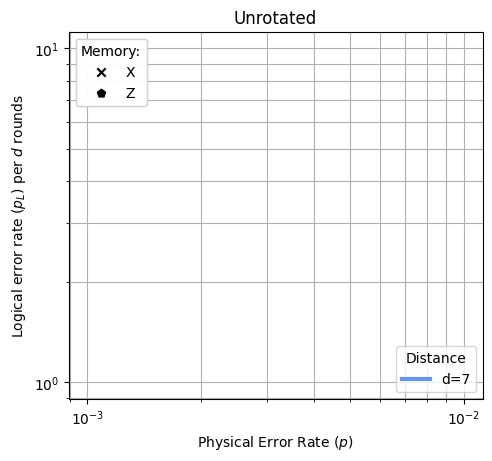

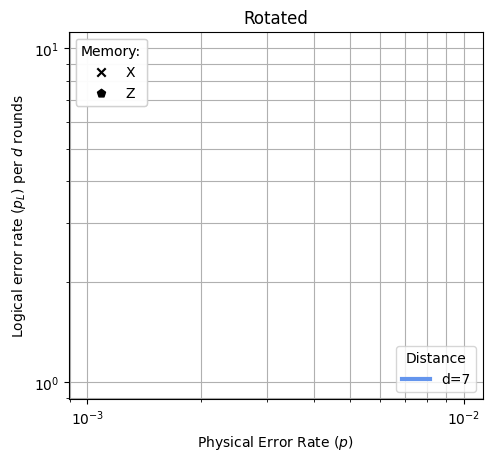

In [ ]:
# python:
reload(funcs)

mylist = sinter.stats_from_csv_files(f'collected_stats/example_stats.csv')

funcs.plot_thresholds(mylist, ro_CNOT_order, unro_CNOT_order, ylims = [None, None]) # note different y-axis scalings

##### Fit to scaling function $p_L = \alpha ( p / \beta)^{\gamma d - \delta}$

In [89]:
reload(funcs)
distances = 'combined' # choices are 'odd', 'even' or 'combined'
b = 'z' # choices are x or z 

funcs.fit_scaling_and_plot(mylist, distances, b, ro_CNOT_order, unro_CNOT_order, minp = min(p_values), maxp = max(p_values)) 

Need at least two combined distances to perform fit. Skipping this function.


##### Plot as $p_L$ vs. $\sqrt{n}$

ValueError: Cannot calculate a linear regression if all x values are identical

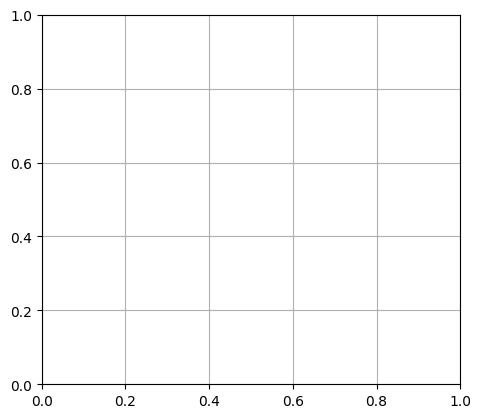

In [90]:
reload(funcs)

b = 'z' 

mylist = sinter.stats_from_csv_files(f'collected_stats/example_stats.csv')
# 
funcs.plot_pL_vs_qubit_count(mylist, b, ro_CNOT_order, unro_CNOT_order)

##### Plot 'teraquop' count :$\ $ the number of qubits required to reach $p_L = 10^{-12}$

In [ ]:
reload(funcs)
funcs.plot_teraquop(mylist, b, ro_CNOT_order, unro_CNOT_order, optional_plot = False)

<IPython.core.display.Math object>

ZeroDivisionError: division by zero

##### Plot ratios of qubit counts vs. $p_L$

This is the projected number of qubits used by the rotated surface code divided by the number of qubits used by the unrotated surface code to achieve the same $p_L$

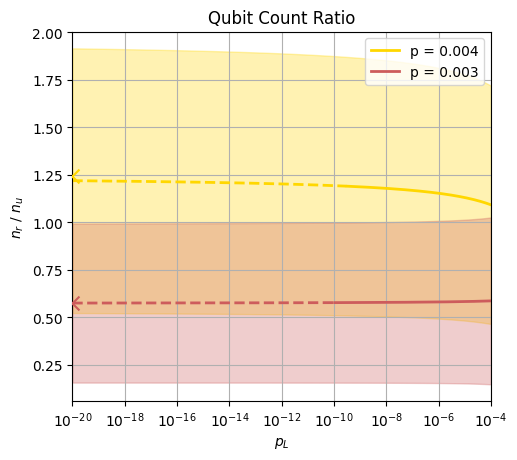

In [128]:
reload(funcs)

funcs.plot_ratio(mylist, b, ro_CNOT_order, unro_CNOT_order)

##### Memory time vs. $\sqrt{n}$

This is a reformulation of the $p_L$ vs. $\sqrt{n}$ plots above, converting the $p_L$ per $d$ rounds to be the length of time (assuming one stabiliser measurement cycle take a microsecond) before $p_L$ over the entire shot of the memory experiment equals $p$.

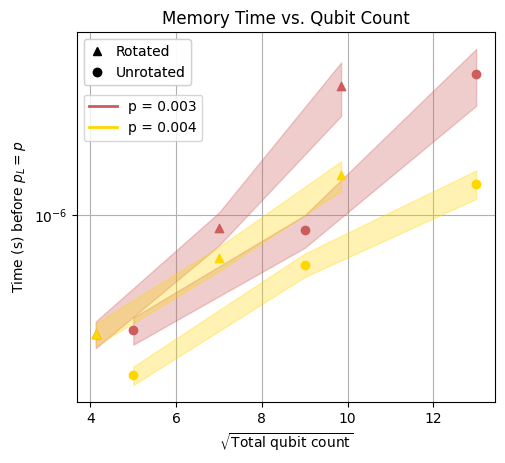

In [129]:
funcs.plot_memory_times(mylist, b, ro_CNOT_order, unro_CNOT_order)